In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import warnings
import time
import math

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['backend'] = 'SVG'

In [3]:
data_path = 'E:/论文/论文2/数据/'
fig_path = 'E:/论文/论文2/论文图片/'
df=pd.read_excel(data_path+'所有数据.xlsx')

佣金变化对结果的影响  
黄金佣金:0.01-0.16  
比特币佣金：0.02-0.17

In [4]:
ub_gold = 0.55 # 黄金买0.55，卖0.45,中间不动
lb_gold = 0.45 
ub_bt = 0.8   # 比特币买0.8，卖0.6
lb_bt = 0.6
assets=[]
for per_gold in np.arange(0.01,0.16,0.01):
    for per_bt in np.arange(0.02,0.17,0.01):
        df['总资产'][0]=1000.0
        df['现金持有份额'][0]=1000.0
        df['黄金持有份额'][0]=0.0
        for i in range(1,df.shape[0]):
            bt = df['比特币买入评分'][i]
            df['当前黄金利润'][i]=df['当前黄金利润'][i-1]+df['黄金价格差分'][i-1]*df['黄金持有份额'][i-1]
            df['当前比特币利润'][i]=df['当前比特币利润'][i-1]+df['比特币价格差分'][i-1]*df['比特币持有份额'][i-1]
            df['黄金持有份额'][i]=df['黄金持有份额'][i-1]
            df['现金持有份额'][i]=df['现金持有份额'][i-1]
            df['比特币持有份额'][i]=df['比特币持有份额'][i-1]
            if df['DealDay'][i]:  # 判断交易日
                gold = df['黄金买入评分'][i]
                if gold > ub_gold:
                    if bt > ub_bt:# 两者都可买入时
                        if gold-ub_gold>(bt-ub_bt)*2:  # 买入黄金
                            df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                            df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
        #                     print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                        else:  # 买入比特币
                            df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*(1-per_bt)/df['Value'][i-1]
                            df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
        #                     print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
                    else: # 只能买黄金时
                        df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                        df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
        #                 print('只能买黄金',df['黄金持有份额'][i])
                if gold<lb_gold:  # 买入黄金
                    df['黄金持有份额'][i]=df['黄金持有份额'][i-1]-df['黄金持有份额'][i-1]*(1+gold-ub_gold)
                    df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['黄金持有份额'][i-1]*(1+gold-ub_gold)*(1-per_gold)*df['USD (PM)'][i-1]
        #             print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
                continue    
            if bt > ub_bt:  # 买入比特币
                df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
                df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
        #         print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
            if bt < lb_bt:  # 卖出比特币
                df['比特币持有份额'][i]=df['比特币持有份额'][i-1]-df['比特币持有份额'][i-1]*(1+gold-lb_bt)
                df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['比特币持有份额'][i-1]*(1+gold-lb_bt)*(1-per_gold)*df['Value'][i-1]
        #         print('卖比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
        df['总资产']=df['黄金持有份额']*df['USD (PM)']+df['比特币持有份额']*df['Value']+df['现金持有份额']
        assets.append(df['总资产'].max())
assets

[19748534.560573615,
 16999887.0868291,
 14613771.43315826,
 12545052.331311718,
 10753875.22858686,
 9205088.654506126,
 7867725.311143154,
 6714536.37720228,
 5721573.989142054,
 4867817.298998663,
 4134837.9106716467,
 3506500.866690158,
 2968697.6981416447,
 2509108.363632071,
 2116989.190841986,
 1782984.1983033982,
 16560354.488719016,
 14257992.713089269,
 12258954.961077752,
 10525521.497665424,
 9024380.393479286,
 7726145.972555231,
 6604926.153408765,
 5637934.101911847,
 4805140.007395615,
 4088959.155789067,
 3473972.807582805,
 2946678.695969657,
 2495268.2435299363,
 2109427.856051277,
 1780161.8911452491,
 1499635.1187830672,
 13864987.957126664,
 11939524.505842766,
 10267437.634467276,
 8817256.257668063,
 7561182.398689201,
 6474690.408380431,
 5536166.823772381,
 4726587.063203695,
 4029225.4807105144,
 3429395.602821619,
 2914217.647814148,
 2472410.682526507,
 2094107.0065407446,
 1770686.5693868874,
 1494629.42474438,
 1259384.407694171,
 11589695.755401446,
 998

In [5]:
df['总资产']

0         1000.000000
1          864.717289
2          860.811880
3          858.861175
4          847.824715
            ...      
1757    133677.092316
1758    136022.590766
1759    120869.757717
1760    118982.725534
1761    119732.358552
Name: 总资产, Length: 1762, dtype: float64

In [6]:
gold_ = []
bt_ = []
for per_gold in np.arange(0.01,0.16,0.01):
    for per_bt in np.arange(0.02,0.17,0.01):
        gold_.append(per_gold)
        bt_.append(per_bt)

In [7]:
df_a = pd.DataFrame()
df_a['黄金佣金']=gold_
df_a['比特币佣金']=bt_
df_a['总资产']=assets
df_a.head()

,黄金佣金,比特币佣金,总资产
0,0.01,0.02,1.974853e+07
1,0.01,0.03,1.699989e+07
2,0.01,0.04,1.461377e+07
3,0.01,0.05,1.254505e+07
4,0.01,0.06,1.075388e+07


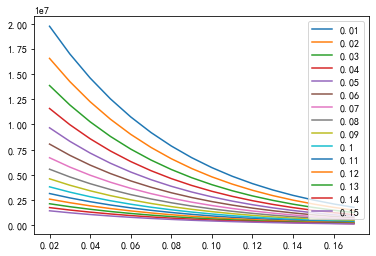

In [8]:
for per_gold in np.arange(0.01,0.16,0.01):
    df1 = df_a[df_a['黄金佣金']==per_gold]
    plt.plot(df1['比特币佣金'],df1['总资产'])
plt.legend([np.round(per_gold,2) for per_gold in np.arange(0.01,0.16,0.01)])
plt.show()

In [9]:
df_a.to_excel(data_path+'佣金-总资产表.xlsx',index=False)